In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
from pymoo.core.problem import ElementwiseProblem

## 1-NSGA2

In [75]:
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=4, #x is a one-dimensional NumPy array of length n_var=2
                         n_obj=2, #number of objectives
                         n_constr=4, #number of constraints
                         xl=np.array([0.125,0.1,0,0]), #lower
                         xu=np.array([10,10,10,5]) #upper
                        )
    
    def _evaluate(self, x, out, *args, **kwargs): 
        #x:variable(numpy array), out:output(dictionary). 
        #out["F"]: numpy array with n_obj length, objective values are written here.
        #out["G"]: numpy array with n_constr length, constraints values are written here. 
        
        f1 = 1.10471 * x[0]**2 * x[1] + 0.04811*x[2]*x[3]*(14.0+x[1])
        f2 = 2.1952/ x[2]**3 / x[3]
        
        tau_dash = 6000/np.sqrt(2)/x[0]/x[1]
        tau_dash2 = 6000*(14+0.5*x[1])*np.sqrt(0.25*(x[1]**2+(x[0]+x[2])**2))  /  (2*0.707*x[0]*x[1]*(x[1]**2/12+0.25*(x[1]**2+(x[0]+x[2])**2)))
        tau = np.sqrt(tau_dash**2 + tau_dash2**2 + x[1]*tau_dash*tau_dash2 / np.sqrt(0.25*(x[1]**2+(x[0]+x[2])**2)))
        
        sigma = 504000/x[2]**2/x[3]
        pc = 64764.022*(1-0.0282346*x[2])*x[2]*x[3]**3
        
        #constraints: g must be zero or negative
        g1 = tau-13600
        g2 = sigma-30000
        g3 = x[0]-x[3]
        g4 = 6000-pc
        
        out["F"] = [f1,f2]
        out["G"] = [g1,g2,g3,g4]                         

In [76]:
problem = MyProblem()

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

In [ ]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 400)

In [ ]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               #seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  6.84410E+05 |       3 |            - |            -
    2 |     140 |  0.00000E+00 |  1.96483E+02 |       4 |  0.170164758 |        ideal
    3 |     180 |  0.00000E+00 |  1.365070110 |       7 |  0.004949255 |        ideal
    4 |     220 |  0.00000E+00 |  0.400691866 |      10 |  0.026661197 |        ideal
    5 |     260 |  0.00000E+00 |  0.021125734 |      12 |  0.004794443 |        ideal
    6 |     300 |  0.00000E+00 |  0.00000E+00 |      12 |  2.133149099 |        nadir
    7 |     340 |  0.00000E+00 |  0.00000E+00 |      14 |  0.149969523 |        nadir
    8 |     380 |  0.00000E+00 |  0.00000E+00 |      15 |  0.482908159 |        nadir
    9 |     420 |  0.00000E+00 |  0.00000E+00 |      17 |  0.028090571 |        nadir
   10 |     460 |  0.00000E+00 |  0.00000E+00 |      15 |  0.009416313 |        ideal
   11 |     500 |  0.00000E+00 |  0.00000E+00 |      1

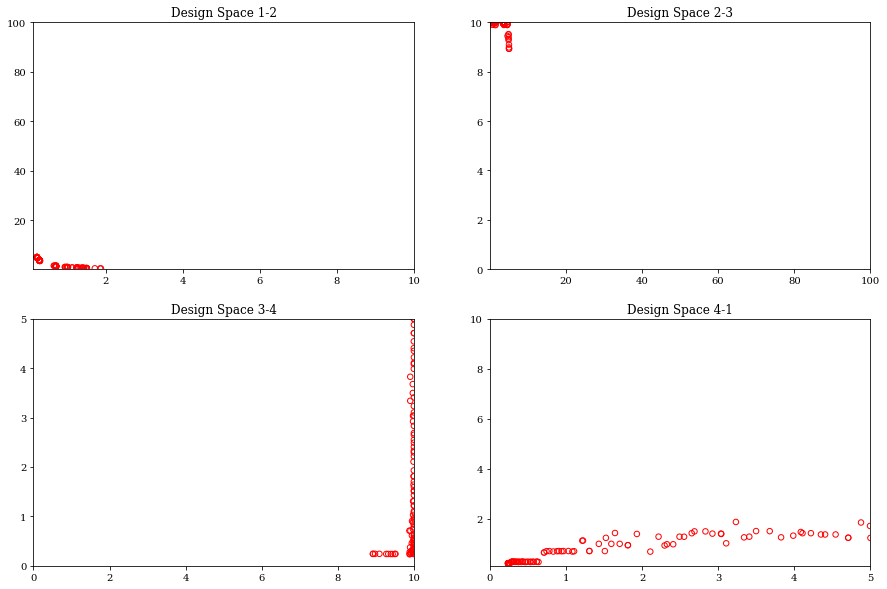

In [ ]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
ax1.set_xlim(xl[0], 10)
ax1.set_ylim(xl[1], 100)
ax1.set_title("Design Space 1-2")

ax2.scatter(X[:, 1], X[:, 2], s=30, facecolors='none', edgecolors='r')
ax2.set_xlim(xl[1], 100)
ax2.set_ylim(xl[2], xu[2])
ax2.set_title("Design Space 2-3")

ax3.scatter(X[:, 2], X[:, 3], s=30, facecolors='none', edgecolors='r')
ax3.set_xlim(xl[2], xu[2])
ax3.set_ylim(xl[3], xu[3])
ax3.set_title("Design Space 3-4")

ax4.scatter(X[:, 3], X[:, 0], s=30, facecolors='none', edgecolors='r')
ax4.set_xlim(xl[3], xu[3])
ax4.set_ylim(xl[0], 10)
ax4.set_title("Design Space 4-1")

fig.show()


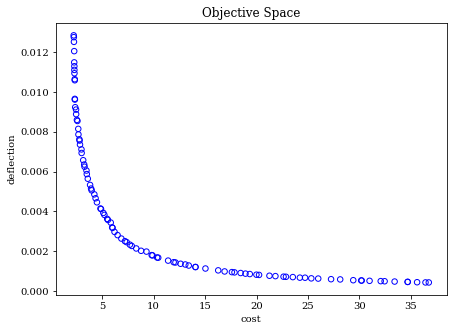

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.xlabel("cost")
plt.ylabel("deflection")
#plt.ylim(0,0.001)
plt.title("Objective Space")
plt.show()

## C-TAEA

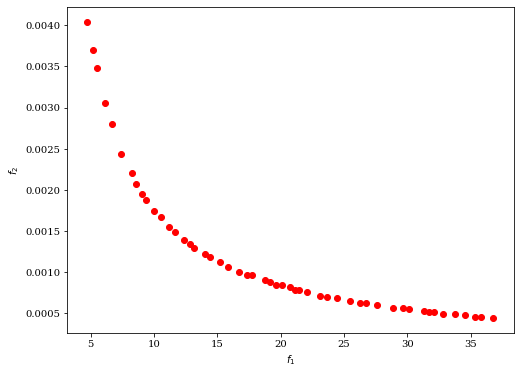

In [ ]:
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

#problem = get_problem("c1dtlz1", None, 3, k=5)

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)

# create the algorithm object
algorithm = CTAEA(ref_dirs=ref_dirs)

# execute the optimization
res = minimize(problem,
               algorithm,
               ('n_gen', 600),
               seed=1
               )

sc = Scatter(legend=False, angle=(45, 30))
sc.add(problem.pareto_front(ref_dirs), plot_type='surface', alpha=0.2, label="PF", color="blue")
sc.add(res.F, color="red")
sc.show()

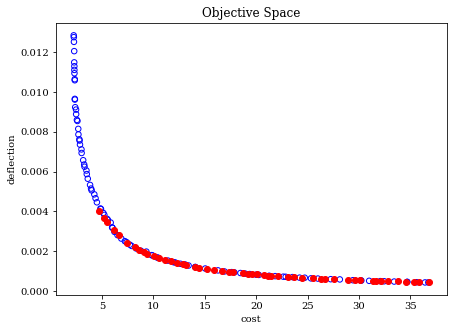

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.xlabel("cost")
plt.ylabel("deflection")

plt.scatter(res.F[:,0], res.F[:,1], color='red')

plt.title("Objective Space")
plt.show()